In [ ]:
!pip install tweepy
!pip install pyspellchecker
!pip install sentence-transformers
!pip install pprint
!pip install scipy
!pip install afinn
!pip install newsapi-python

     |████████████████████████████████| 1.9MB 7.2MB/s 
     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 778kB 17.4MB/s 
     |████████████████████████████████| 1.1MB 42.0MB/s 
     |████████████████████████████████| 3.0MB 41.6MB/s 
     |████████████████████████████████| 890kB 42.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.2-cp36-none-any.whl size=93964 sha256=a9f5b3b931e507330bc926df6bfec507262561b62844456b19b2ded2d213503c
  Stored in directory: /root/.cache/pip/wheels/f7/06/a0/567f3651876165429f6510d3197b011652a25e547552816824
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=09d7e703043334d2b745223d2cc64c7c697ee86a525fe1b81016c4e538280d6e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
  Created wheel for pprint: filename=pprint-0.1-cp36-none-a

In [ ]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
from spellchecker import SpellChecker
import nltk
nltk.download('stopwords')#Error loading
nltk.download('punkt')#Error loading
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.tokenize import word_tokenize 
from nltk import word_tokenize, pos_tag
from nltk.stem import SnowballStemmer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import pickle
from sklearn.cluster import KMeans

import gensim
from gensim import corpora
import scipy as scipy

import spacy
from spacy import displacy
import en_core_web_sm

from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
from sentence_transformers import SentenceTransformer
import torch
print(torch.cuda.is_available())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True


In [ ]:
path = '/content/drive/My Drive/Hackathon_2020/data'
news_channels = os.path.join(path, 'news_channels')
results_folder = os.path.join(path, 'results')

In [ ]:
df_media_bias = pd.read_csv(os.path.join(path, 'media_bias.csv'), header = 0)
media_bias_dict = dict(zip(df_media_bias['Twitter id'], df_media_bias['bias']))
media_bias_dict

{'AP': 'center',
 'AlJazeera': 'left-center',
 'BreitbartNews': 'right',
 'CBSNews': 'left-center',
 'CNN': 'left',
 'CNNEE': 'left',
 'FoxNews': 'right',
 'HuffPost': 'left-center',
 'MSNBC': 'left',
 'NBCNews': 'left-center',
 'NRO': 'right',
 'NYMag': 'left',
 'NewsWeek': 'left',
 'Reuters': 'center',
 'TIME': 'left-center',
 'USATODAY': 'center',
 'VICENews': 'left-center',
 'WashTimes': 'right-center',
 'abc': 'left-center',
 'amconmag': 'right-center',
 'axios': 'left-center',
 'googlenews': 'left-center',
 'politico': 'center',
 'thehill': 'left-center',
 'washingtonpost': 'left-center'}

In [ ]:
import tweepy

CONSUMER_KEY = 'KEY'
CONSUMER_SECRET = 'KEY'
ACCESS_TOKEN = 'KEY'
ACCESS_TOKEN_SECRET = 'KEY'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

status = "Testing!"
api.update_status(status=status)

In [ ]:
%%time
import datetime
username = 'NYMag' #'HuffPost'#'BreitbartNews' #
startDate = datetime.datetime(2020, 1, 1, 0, 0, 0)
endDate =   datetime.datetime(2020, 7, 23, 0, 0, 0)

tweets = []
tmpTweets = api.user_timeline(username, count=1000)
for tweet in tmpTweets:
    if tweet.created_at < endDate and tweet.created_at > startDate:
        tweets.append(tweet)
print(len(tweets))
while (tmpTweets[-1].created_at > startDate):
    tmpTweets = api.user_timeline(username, max_id = tmpTweets[-1].id)
    for tweet in tmpTweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweets.append(tweet)

In [ ]:
len(tweets)


3262

In [ ]:
import csv, os
csvFile = open(os.path.join(news_channels, '{}.csv'.format(username)), 'a')
csvWriter = csv.writer(csvFile)
csvWriter.writerow(['created_at',  'author_screen_name', 'author_followers_count',
                      'author_name', 'text', 
                      'retweet_count', 'favorite_count', 'coordinates'])
for tweet in tweets:
  #print([tweet.created_at ,tweet.text])
  if tweet:
    csvWriter.writerow([tweet.created_at,  tweet.author.screen_name, tweet.author.followers_count,
                      tweet.author.name, tweet.text, 
                      tweet.retweet_count, tweet.favorite_count, tweet.coordinates])

In [ ]:
import glob, ntpath
files = glob.glob(os.path.join(news_channels, '*.csv'))
print(files)
frame_combined = pd.DataFrame(columns= ['created_at',  'author_screen_name', 
                      'author_followers_count', 'author_name', 'text', 
                      'retweet_count', 'favorite_count', 'coordinates'])
for file in files:
  channel_name = ntpath.basename(file).split('.')[0]
  bias = media_bias_dict[channel_name]
  df_bias = pd.read_csv(file, header = 0)
  frame_combined = pd.concat([frame_combined, df_bias], ignore_index=True)
  print(len(df_bias))
print(len(frame_combined))
frame_combined['bias'] = frame_combined['author_screen_name'].apply(lambda x: media_bias_dict[x])
print(len(frame_combined))
frame_combined.head(5)

['/content/drive/My Drive/Hackathon_2020/data/news_channels/BreitbartNews.csv', '/content/drive/My Drive/Hackathon_2020/data/news_channels/HuffPost.csv', '/content/drive/My Drive/Hackathon_2020/data/news_channels/NYMag.csv']
3689
3303
2994
9986
9986


,created_at,author_screen_name,author_followers_count,author_name,text,retweet_count,favorite_count,coordinates,bias
0,2020-07-22 23:42:17,BreitbartNews,1419476,Breitbart News,MUNRO: Millions of illegal migrants should be ...,151,147,NaN,right
1,2020-07-22 23:16:48,BreitbartNews,1419476,Breitbart News,Big Talker. https://t.co/341384tUzS,575,1755,NaN,right
2,2020-07-22 22:55:04,BreitbartNews,1419476,Breitbart News,Only someone as hyper-partisan as Nancy Pelosi...,217,528,NaN,right
3,2020-07-22 22:52:21,BreitbartNews,1419476,Breitbart News,LIVE: Virginians Hold Pro-Police Rally in Fair...,285,771,NaN,right
4,2020-07-22 22:33:23,BreitbartNews,1419476,Breitbart News,MUNRO: Millions of illegal migrants should be ...,134,135,NaN,right


In [ ]:
frame_combined['text_clean'] = frame_combined.text.apply(lambda x: clean_doc(x))


In [ ]:
frame_combined['text_clean'] = frame_combined['text_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
df_news = frame_combined
df_news.drop_duplicates(inplace=True)
df_news['created_at'] =  pd.to_datetime(df_news['created_at'],  infer_datetime_format=True)

In [ ]:
df_dates =df_news.groupby([df_news['created_at'].dt.date, df_news['author_screen_name']]).count().drop(['created_at'], axis = 1).reset_index()
df_dates

,created_at,author_screen_name,author_followers_count,author_name,text,retweet_count,favorite_count,coordinates,bias
0,2020-05-22,NYMag,43,43,43,43,43,0,43
1,2020-05-23,NYMag,29,29,29,29,29,0,29
2,2020-05-24,NYMag,30,30,30,30,30,0,30
3,2020-05-25,NYMag,30,30,30,30,30,0,30
4,2020-05-26,HuffPost,41,41,41,41,41,0,41
...,...,...,...,...,...,...,...,...,...
172,2020-07-21,HuffPost,69,69,69,69,69,0,69
173,2020-07-21,NYMag,69,69,69,69,69,0,69
174,2020-07-22,BreitbartNews,62,62,62,62,62,0,62
175,2020-07-22,HuffPost,76,76,76,76,76,0,76


In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
configure_plotly_browser_state()
import plotly.express as px
fig = px.line(df_dates, x="created_at", y="author_followers_count", color='author_screen_name')
fig.show()

### Visualization

#### Word Clouds

Started Word Cloud...
Total tokens for wordCloud: 176189


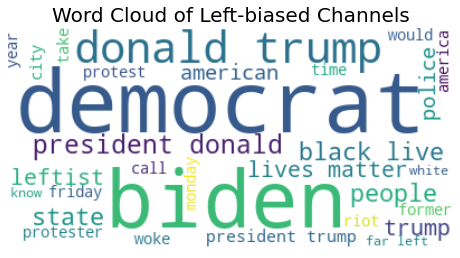

In [ ]:
data_left = df_news[df_news['bias'].isin(['left', 'left-center'])]['text_clean'].values.tolist()
left_sentences = list(sent_to_words(data))
get_word_cloud_with_image(left_sentences, False , 'Left-biased Channels')

Started Word Cloud...
Total tokens for wordCloud: 176189


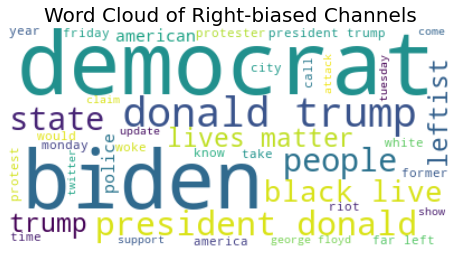

In [ ]:
data_right = df_news[df_news['bias'].isin(['right', 'right-center'])]['text_clean'].values.tolist()
left_sentences = list(sent_to_words(data))
get_word_cloud_with_image(left_sentences, False , 'Right-biased Channels')

#### N-Grams

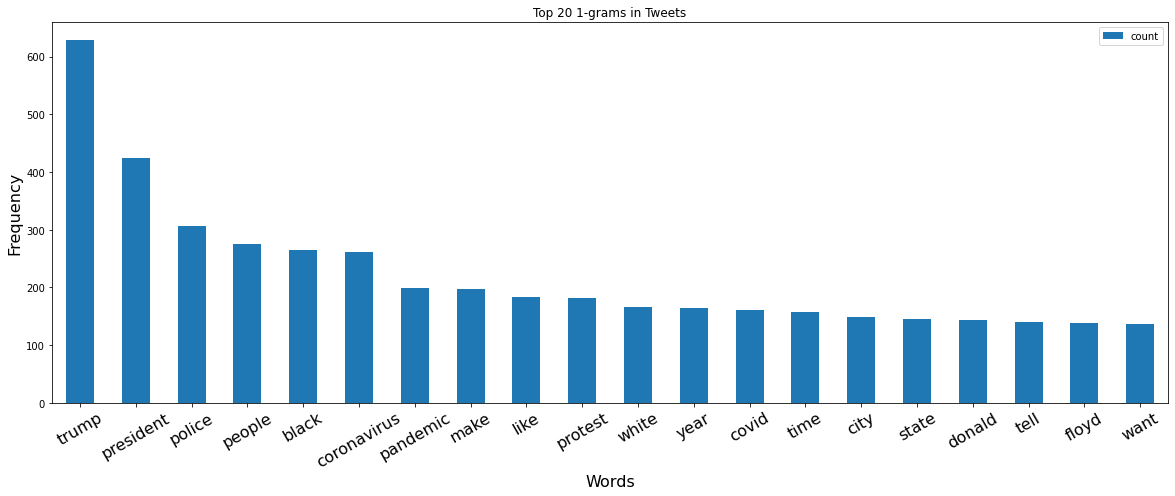

In [ ]:
plot_n_grams(20, data_left, ngram = 1)

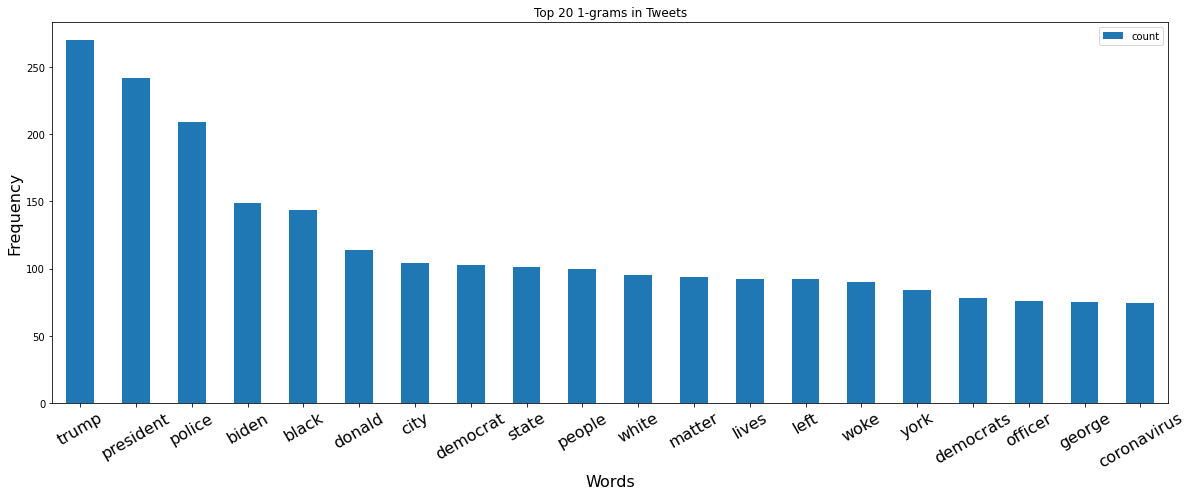

In [ ]:
plot_n_grams(20, data_right, ngram = 1)

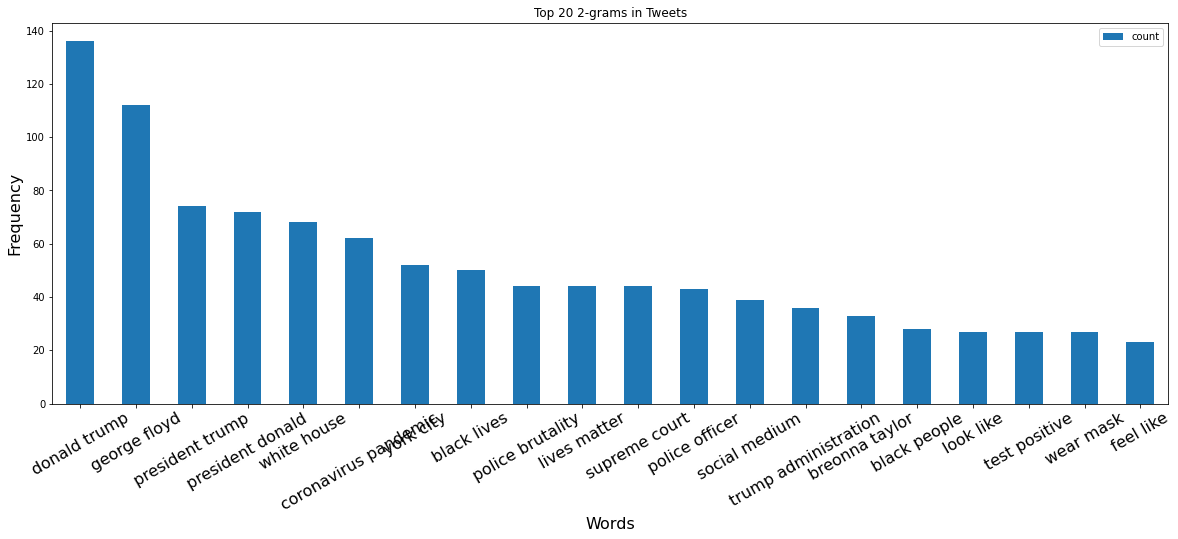

In [ ]:
plot_n_grams(20, data_left, ngram = 2)

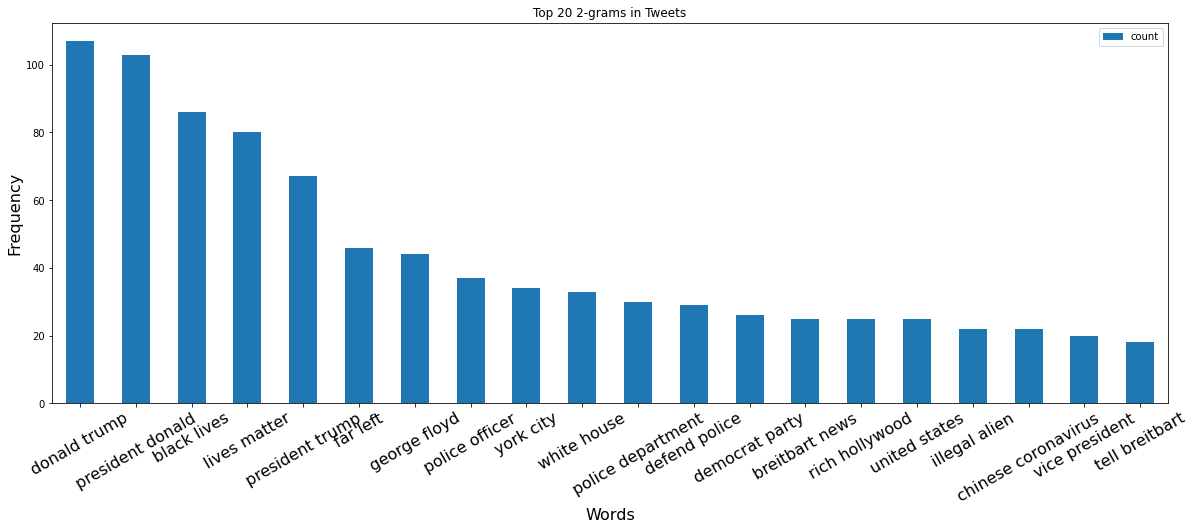

In [ ]:
plot_n_grams(20, data_right, ngram = 2)

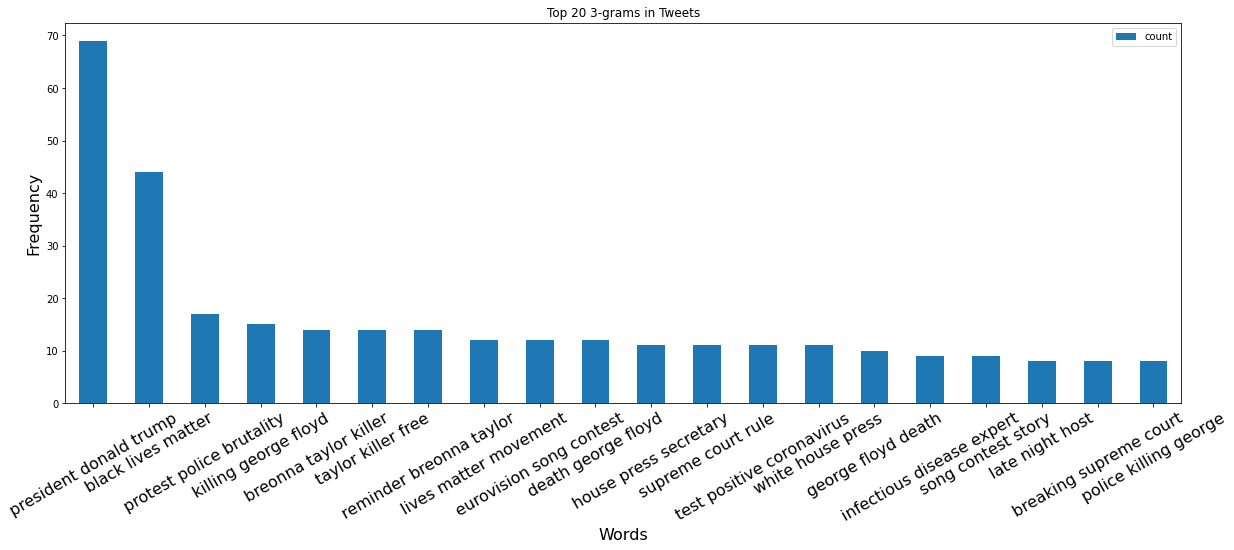

In [ ]:
plot_n_grams(20, data_left, ngram = 3)

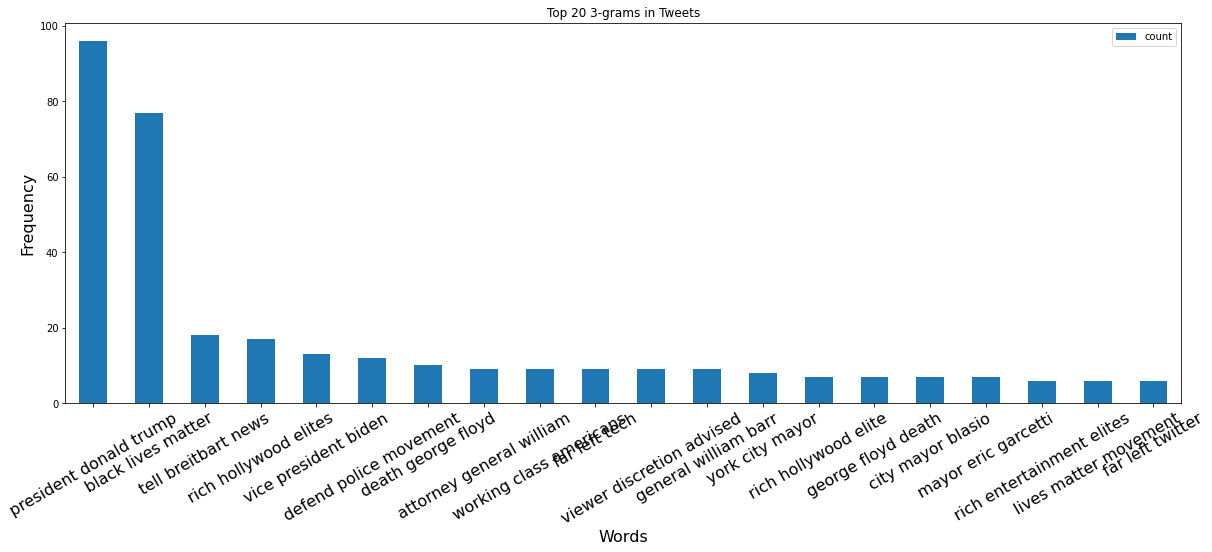

In [ ]:
plot_n_grams(20, data_right, ngram = 3)

In [ ]:
def get_top_n_grams( corpus, n=None, ngram = 1):
        vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]
def plot_n_grams( n, d, ngram= 1):
        common_words = get_top_n_grams(d, n = n, ngram = ngram)
        df4 = pd.DataFrame(common_words, columns = ['words' , 'count'])
        df4 = df4.groupby('words').sum()['count'].reset_index(name='count').sort_values(by = ['count'], ascending=False)
        df4.index = df4['words']
        #print(df4)
        df4.plot(kind = 'bar' , figsize=(20, 7))
        plt.title('Top {} {}-grams in Tweets'.format(n, ngram))
        plt.xticks( rotation = 30, fontsize = 16, horizontalalignment="center")
        #plt.yticks( fontsize = 16, horizontalalignment="center")
        plt.xlabel("Words", fontsize = 16)
        plt.ylabel("Frequency", fontsize = 16)
        plt.savefig(os.path.join(results_folder, "ngram_{}.png".format(ngram)))

In [ ]:
import itertools
def sent_to_words( sentences):
        for sent in sentences:
            sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
            sent = re.sub('\s+', ' ', sent)  # remove newline chars
            sent = re.sub("\'", "", sent)  # remove single quotes
            sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
            yield(sent)  
def get_word_cloud_with_image(sentences, is_freq, title= None, image = None ):
        stopwords = set(stop_words)
        stopwords.add(".It")

        print("Started Word Cloud...")
        tokens = list(itertools.chain.from_iterable(sentences))
        data = " ".join([i for i in tokens if not i.lower() in stop_words])
        print("Total tokens for wordCloud: {}".format(len(data)))
        if is_freq:
            wc = WordCloud( max_words=2000, mask=image, width = 800, height = 800,
                        background_color ='white', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate_from_frequencies(data)
        else:
            wc = WordCloud( max_words=2000, mask=image,
                        background_color ='white', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(data)

        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.title('Word Cloud of {}'.format(title), size =20)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(os.path.join(results_folder, 'word_cloud_{}.png'.format(title)))
        plt.show()

### Article Sentiments

In [ ]:
# initialize afinn sentiment analyzer

from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(tweet) for tweet in df_news['text_clean'].values]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
df_news['sentiment_score'] = sentiment_scores
df_news['sentiment_category']  = sentiment_category
print(df_news.head(5))   
print(df_news.columns) 
# sentiment statistics per news category
df_senti = pd.DataFrame([list(df_news['text']), list(df_news['retweet_count']), list(df_news['text_clean']), sentiment_scores, sentiment_category]).T
df_senti.columns = ['tweet','retweet_count',  'cleaned_text', 'sentiment_score', 'sentiment_category']
df_senti['sentiment_score'] = df_senti.sentiment_score.astype('float')
df_senti.head(5)

           created_at author_screen_name  ... sentiment_score sentiment_category
0 2020-07-22 23:42:17      BreitbartNews  ...            -2.0           negative
1 2020-07-22 23:16:48      BreitbartNews  ...             0.0            neutral
2 2020-07-22 22:55:04      BreitbartNews  ...             2.0           positive
3 2020-07-22 22:52:21      BreitbartNews  ...             0.0            neutral
4 2020-07-22 22:33:23      BreitbartNews  ...            -2.0           negative

[5 rows x 12 columns]
Index(['created_at', 'author_screen_name', 'author_followers_count',
       'author_name', 'text', 'retweet_count', 'favorite_count', 'coordinates',
       'bias', 'text_clean', 'sentiment_score', 'sentiment_category'],
      dtype='object')


,tweet,retweet_count,cleaned_text,sentiment_score,sentiment_category
0,MUNRO: Millions of illegal migrants should be ...,151,munro millions illegal migrant allow take lice...,-2.0,negative
1,Big Talker. https://t.co/341384tUzS,575,talker,0.0,neutral
2,Only someone as hyper-partisan as Nancy Pelosi...,217,someone hyperpartisan nancy pelosi could hail ...,2.0,positive
3,LIVE: Virginians Hold Pro-Police Rally in Fair...,285,live virginian hold propolice rally fairfax,0.0,neutral
4,MUNRO: Millions of illegal migrants should be ...,134,munro millions illegal migrant allow take lice...,-2.0,negative


### Public Tweet Data

In [ ]:
df_geotagged = pd.read_csv(os.path.join(path, 'all_tweets_usa.csv'),
                           header = 0, sep = ',', error_bad_lines=False, encoding = "ISO-8859-1", parse_dates = True)
df_geotagged = df_geotagged.drop(['Unnamed: 0'], axis = 1)
df_geotagged.drop_duplicates(inplace=True)
df_geotagged = df_geotagged[df_geotagged['text'].notna()]
df_geotagged['is_retweet'] = df_geotagged['text'].apply(lambda x: x[:2]=='RT')
print("Total number of Retweets: {}".format(df_geotagged['is_retweet'].sum()))
df_geotagged

### Data Cleaning

In [ ]:
#Utility function for data preprocessing (METHOD 1)
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
stemmer = SnowballStemmer("english")

def cleanHtml(sentence):
    cleanr = re.compile(r"http\S+")
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
def replace_mentioned(tweet):
        '''This function will extract the twitter handles of people mentioned in the tweet'''
        return re.sub('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)',"", tweet)
    
def find_hashtags(sentence):
        '''This function will extract hashtags'''
        return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', "", sentence)
def fix_abbreviation(text):
    text = re.sub(r'\b(?:vs|VS|Vs)\b\.*', 'versus', text)
    text = re.sub(r"'ve\b", ' have', text)
    # text = re.sub(r"\b(btw|BTW)\b", 'by the way', text)
    # text = re.sub(r"\b(asap|ASAP)\b", 'as soon as possible', text)
    # text = re.sub(r"\b(af|AF)\b", 'as fuck', text)
    # text = re.sub(r"\b(AFAIK)\b", 'as far as I know', text)
    text = re.sub(r"\b(DM)\b", 'direct message', text)
    text = re.sub(r"\b(EM)\b", 'email', text)
    text = re.sub(r"\b(FB)\b", 'facebook', text)
    # text = re.sub(r"\b(OMG)\b", 'oh my god', text)
    return text

def remove_extras(text):
    # Remove 'RT'
    text = re.sub(r'RT\b', '', text)
    # Remove user's handle and email addres
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove links
    text = re.sub(r'http(s)?\:\/\/t\.co\/\w*', '', text)
    # Remove digits and words that has digit(s) except those network related
    # text = re.sub(r'(?!5g|5G|4g|4G|3g|3G|2g|2G)\w*\d+\w*', '', text)
    text = re.sub(r'\W\b(\d+)\b', '', text)
    # Remove '-'
    text = re.sub(r'-', '', text)
    # Remove distracting double quotes
    text = re.sub(r"\”", '\"', text)
    text = re.sub(r"\“", '\"', text)
    text = re.sub(r"\"", '', text)
    # Remove distracting single quotes
    text = re.sub(r"\’", '\'', text)
    text = re.sub(r"\‘", '\'', text)
    text = re.sub(r"\'s", '', text)
    # text = re.sub(r"\'ve", ' have', text)
    text = re.sub(r"\'", '', text)
    # Remove extra whitespaces
    text = ' '.join([word for word in text.split()])

    return text
def reduce_lengthening(text):
    """
    Fixing Word Lengthening ~ finalllly -> finally
    """
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

def clean_HT_MT_Html(text):
  text = replace_mentioned(text)
  #text = find_hashtags(text)
  text = cleanHtml(text)
  text = clean_ascii(text)
  # Remove punctuations
  punc_free = ''.join([ch for ch in text if ch not in string.punctuation])

  # Fix misspelled words
  text = ' '.join([spell.correction(word) for word in punc_free.split()])
  text = text.strip()
  return text


In [ ]:
#Utility function for data preprocessing (METHOD 2)

stop_words = stopwords.words('english')
stop_words.extend(['zero','is','lol','yr','fu', 'weeks','im', 'u','one', 'day', 'week', 'two', 'dont', 'it', 'isnt',"isn't", "don't",'not','yes','no','next'])
puncs = string.punctuation
lemma = WordNetLemmatizer()
spell = SpellChecker(distance=1)
# Add unknown words to spell checker
spell.word_frequency.load_words(['Covid', 'covid', 'COVID', 'corona'])

def clean_doc(text):
    # pdb.set_trace()

    # Fix some common abbreviations
    text = fix_abbreviation(text)
    text = cleanHtml(text)
    text = replace_mentioned(text)
    #text = find_hashtags(text)

    # Remove unnecessary tokens like username, email and '-'
    text = remove_extras(text)
    # Remove extra repeated characters

    text = reduce_lengthening(text)
    
    text = keepAlpha(text)
    # Remove punctuations
    punc_free = ''.join([ch for ch in text if ch not in puncs])

    # Fix misspelled words
    spell_corrected = ' '.join([spell.correction(word) for word in punc_free.split()])

    # Lemmatize word using WordNetLemmatizer
    # Define word's role (POS) for better lemmatization result
    lemmaztized_words = []
    for word, pos in nltk.pos_tag(spell_corrected.split()):
        if pos[:2] == 'VB':     # if verb
            tag = 'v'
        elif pos[:2] == 'JJ':   # if adjective
            tag = 'a'
        else:
            tag = 'n'
        lemmaztized_words.append(lemma.lemmatize(word, pos=tag))
    normalized = ' '.join([word for word in lemmaztized_words])

    # Remove stop words
    stop_free = ' '.join([word for word in normalized.lower().split() if word not in stop_words])

    return stop_free

In [ ]:
df = df_geotagged
#Use this text_clean for non-BERT purposes
df['text_clean'] = df.text.apply(lambda x: clean_doc(x))

In [ ]:
from pprint import pprint
pprint(df[['text', 'text_clean']].head(1)['text'][0])
pprint(df[['text', 'text_clean']].head(1)['text_clean'][0])

In [ ]:
# initialize afinn sentiment analyzer

from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(tweet) for tweet in df['text_clean'].values]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
df['sentiment_score'] = sentiment_scores
df['sentiment_category']  = sentiment_category
print(df.columns)    
# sentiment statistics per news category
df_senti = pd.DataFrame([list(df['text']), list(df['text_clean']), sentiment_scores, sentiment_category]).T
df_senti.columns = ['tweet', 'cleaned_text', 'sentiment_score', 'sentiment_category']
df_senti['sentiment_score'] = df_senti.sentiment_score.astype('float')
df_senti.head(5)

In [ ]:
df.to_csv(os.path.join(path, 'geotagged_US_tweets_sentiment.csv'))

In [ ]:
df_senti = pd.read_csv(os.path.join(path, 'geotagged_US_tweets_sentiment.csv'),
                           header = 0, sep = ',', error_bad_lines=False, encoding = "ISO-8859-1", parse_dates = True)

In [ ]:
len(df_senti)

55014

### NEWS API analysis


In [ ]:
from newsapi import NewsApiClient
newsapi = NewsApiClient(api_key="key")


In [ ]:
all_articles = newsapi.get_everything(
                                      sources='breitbart-news',
                                      from_param='2020-06-25',
                                      to='2020-07-23',
                                      language='en',
                                      sort_by='relevancy'
                                      )

In [ ]:
len(pd.DataFrame(all_articles['articles']))

20

In [ ]:
pd.DataFrame(all_articles['articles'])

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Amy Furr,Darden Restaurants Says 60K Furloughed Employe...,"The Darden Restaurants company in Orlando, Flo...",https://www.breitbart.com/economy/2020/06/25/d...,https://media.breitbart.com/media/2020/06/Oliv...,2020-06-25T20:45:37Z,"The Darden Restaurants company in Orlando, Flo..."
1,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",John Carney,Consumer Sentiment Slipped In Late June,Consumer sentiment improved from May but slipp...,https://www.breitbart.com/economy/2020/06/26/j...,https://media.breitbart.com/media/2020/06/Gett...,2020-06-26T14:35:12Z,Consumer sentiment rose for the second consecu...
2,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Dr. Susan Berry,Trump Administration Asks Supreme Court to Inv...,The Trump administration filed a brief with th...,https://www.breitbart.com/politics/2020/06/26/...,https://media.breitbart.com/media/2018/11/Obam...,2020-06-26T14:31:21Z,The Trump administration filed a brief Thursda...
3,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...","David Ng, \nDavid Ng","Laverne Cox, Kamala Harris Push to Defund Poli...",Transgender Hollywood star Laverne Cox and Sen...,https://www.breitbart.com/entertainment/2020/0...,https://media.breitbart.com/media/2020/06/lave...,2020-06-26T14:20:25Z,Transgender Hollywood star Laverne Cox and Sen...
4,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",John Binder,Survey: 8-in-10 Police Officers Would Not Reco...,"About 8-in-10 police officers of about 10,000 ...",https://www.breitbart.com/politics/2020/07/02/...,https://media.breitbart.com/media/2020/06/Cop-...,2020-07-02T23:44:33Z,"About 8-in-10 police officers of about 10,000 ..."
5,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Amy Furr,Texas Gov. Greg Abbott Issues Statewide Mask R...,All Texans are required to wear masks in publi...,https://www.breitbart.com/health/2020/07/02/te...,https://media.breitbart.com/media/2020/07/AP_2...,2020-07-03T00:07:43Z,All Texans are required to wear masks in publi...
6,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Warner Todd Huston,UT’s Demarvion Overshown Boycotting Team Until...,University of Texas linebacker DeMarvion Overs...,https://www.breitbart.com/sports/2020/07/02/ut...,https://media.breitbart.com/media/2020/07/Gett...,2020-07-02T23:03:41Z,University of Texas linebacker DeMarvion Overs...
7,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",UPI,Stadium Sponsor FedEx Requests Washington Reds...,"July 2 (UPI) -- FedEx, which holds the naming ...",https://www.breitbart.com/sports/2020/07/02/st...,https://media.breitbart.com/media/2020/07/UPI-...,2020-07-03T02:34:56Z,"July 2 (UPI) — FedEx, which holds the naming r..."
8,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...","Jeff Poor, \nJeff Poor",Hawley: Black Lives Matter 'Trying to Hijack' ...,"Thursday on Fox News Channel's ""Fox & Friends,...",https://www.breitbart.com/clips/2020/07/02/haw...,https://media.breitbart.com/media/2020/07/Hawl...,2020-07-02T17:10:12Z,Thursday on Fox News Channel’s “Fox &amp; Frie...
9,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...","Chris Tomlinson, \nChris Tomlinson",Sebastian Kurz Accused Erdogan of Stoking Tens...,Austrian Chancellor Sebastian Kurz has accused...,https://www.breitbart.com/europe/2020/07/01/se...,https://media.breitbart.com/media/2017/12/Gett...,2020-07-01T17:46:55Z,Austrian Chancellor Sebastian Kurz has accused...


In [ ]:
len(pd.DataFrame(newsapi.get_top_headlines(sources='breitbart-news')['articles']))

10

#### Cleaning Tweet ID files

In [ ]:
df_out4 = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/out_4.tsv', sep = '\t', header = None)
df_out4.columns = ['id', 'date', 'time']
print(len(df_out4))
df_out4.head(5)

57625


,id,date,time
0,1282730135582638080,2020-07-13,17:34:30
1,1282726538031566852,2020-07-13,17:20:13
2,1282726529060012035,2020-07-13,17:20:11
3,1282725977303535622,2020-07-13,17:17:59
4,1282725986576920576,2020-07-13,17:18:01


In [ ]:
df_out4[['id']].to_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/out_cleaned_4.csv',  header = None, index = False)

In [ ]:
pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/out_cleaned_4.csv', sep = '\t', header = None)

,0
0,1282730135582638080
1,1282726538031566852
2,1282726529060012035
3,1282725977303535622
4,1282725986576920576
...,...
57620,1284657191031537664
57621,1284657181590278145
57622,1284657124040159232
57623,1284657393180332032


In [ ]:
df_out4 = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/all_out.csv', sep = '\t', header = None)
df_out4.columns = ['id', 'date', 'time']
print(len(df_out4))
df_out4.head(5)

230512


,id,date,time
0,1276109732504313856,2020-06-25,11:07:23
1,1276109704385556480,2020-06-25,11:07:17
2,1276109642402275329,2020-06-25,11:07:02
3,1276109682923442176,2020-06-25,11:07:12
4,1276109677642776584,2020-06-25,11:07:10


In [ ]:
df_out4.drop_duplicates(inplace=True)
len(df_out4)

230423

In [ ]:
df_ieee = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/all_tweets_usa.csv',  header = 0)
#df_out4.columns = ['id', 'date', 'time']
print(len(df_ieee))
df_ieee.head(5)

319788


,Unnamed: 0,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,reweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,0,"-74.0064,40.7142",Fri Apr 10 04:26:17 +0000 2020,follow alone apocalypse corona covid nyc manha...,NaN,https://www.instagram.com/p/B-yWtu4HcFO/?igshi...,0,1.24847e+18,NaN,NaN,NaN,en,"Manhattan, NY",False,0.0,NaN,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...","At night these days in Manhattan, one can sit ...",https://twitter.com/EmilChynn/status/124846731...,Thu Jan 29 14:13:54 +0000 2009,EmilChynn,False,Grad: Dartmouth Columbia HARVARD Emory NYU Mos...,168.0,1609.0,1250.0,22.0,333 Park Avenue South NY 10010,Emil Chynn,EmilChynn,6135.0,NaN,http://www.ParkAvenueLASEK.com,False
1,8,"-74.0007613,40.7207559",Fri Apr 10 08:09:50 +0000 2020,NaN,NaN,https://www.wordfairy.co.uk/blog/2020/4/10/lov...,4,1.24852e+18,NaN,NaN,NaN,en,"Manhattan, NY",False,0.0,NaN,NaN,"<a href=""http://www.squarespace.com"" rel=""nofo...",Love in the time of corona: happy birthday sis...,https://twitter.com/_wordfairy_/status/1248523...,Fri Apr 01 10:54:50 +0000 2011,_wordfairy_,False,"Writer, mother, would-be runner. Former Singap...",4106.0,313.0,434.0,13.0,"London, England",Morwenna Lawson,_wordfairy_,4121.0,NaN,http://www.wordfairy.co.uk,False
2,12,"-122.2382,38.1135",Fri Apr 10 03:52:06 +0000 2020,NaN,NaN,https://www.instagram.com/p/B-yTGYSgyzr/?igshi...,0,1.24846e+18,NaN,NaN,NaN,en,"Vallejo, CA",True,0.0,NaN,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",I've gain at least 10lbs since this Corona shi...,https://twitter.com/Kreepalo/status/1248458710...,Mon May 07 12:41:31 +0000 2012,Kreepalo,False,Artist in every way.....\r\nhttp://t.co/K8dLa0...,141.0,1676.0,3222.0,14.0,Marietta GA,Planet Kreepalo 818,Kreepalo,5342.0,NaN,http://shaunfosterinc.wix.com/planet-kreepalo-818,False
3,18,"-73.7021,40.6795",Fri Apr 10 04:50:20 +0000 2020,SouthernStateParkway,NaN,NaN,0,1.24847e+18,NaN,NaN,NaN,en,"North Valley Stream, NY",NaN,0.0,NaN,NaN,"<a href=""https://511ny.org"" rel=""nofollow"">NYR...",Cleared: Construction on #SouthernStateParkway...,https://twitter.com/511nyLongIsland/status/124...,Thu Jun 25 18:45:29 +0000 2009,511nyLongIsland,False,Traffic & transit updates for the Long Island ...,0.0,1551.0,0.0,117.0,Long Island,511NY - Long Island,511nyLongIsland,286329.0,NaN,http://twitter.511ny.org/,False
4,19,"-95.7129,37.0902",Fri Apr 10 08:33:18 +0000 2020,StayAtHome CovidUS,NaN,https://corona-scanner.com/country/united-stat...,0,1.24853e+18,neilellis,1.248529e+18,1.42921e+07,en,"Kansas, USA",False,0.0,NaN,NaN,"<a href=""http://google.com"" rel=""nofollow"">t_c...","ðºð¸ US\n\nNotes: Partial Lock-down, Limit...",https://twitter.com/neilellis/status/124852947...,Thu Apr 03 10:13:37 +0000 2008,neilellis,False,"I am a computer programmer, who also spends a ...",32536.0,560.0,259.0,60.0,UK,Neil Ellis,neilellis,34691.0,NaN,NaN,False


In [ ]:
df_ieee.drop_duplicates(inplace=True)
print(len(df_ieee))


61640


In [ ]:
len(set(df_out4['id'].values) & set(df_ieee['id'].values))

1495

In [ ]:
df_out4 = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/out_cleaned_4.csv')
df_out4.drop_duplicates(inplace=True)
print(len(df_out4))
df_out4.head(5)

In [ ]:
df_out3 = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/out3_hydrated.csv')
df_out3.drop_duplicates(inplace=True)
print(len(df_out3))
df_out3.head(5)

In [ ]:
df_out2 = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/06-30-2020_07-06-2020.csv')
df_out2.drop_duplicates(inplace=True)
print(len(df_out2))
df_out2.head(5)

In [ ]:
df_out1 = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/06-25-2020_06-30-2020.csv')
df_out1.drop_duplicates(inplace=True)
print(len(df_out1))


In [ ]:
df_out1.columns

Index(['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_screen_name', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name.1',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')

In [ ]:
frame_combined = pd.DataFrame(columns= ['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_screen_name', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name.1',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'])

frame_combined = pd.concat([df_out1, df_out2, df_out3, df_out4], ignore_index=True)
len(frame_combined)

218787

In [ ]:
frame_combined.drop_duplicates(inplace=True)
len(frame_combined)

218787

In [ ]:
frame_combined.head(5)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,reweet_id
0,NaN,Thu Jun 25 11:07:10 +0000 2020,NaN,NaN,NaN,0,1276109677642776584,Fiorella_im,1.275981e+18,45500908.0,en,"New Hampshire, USA",NaN,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...","@Fiorella_im Hence, the coronavirus pandemic.",https://twitter.com/wanderlustyogi/status/1276...,Wed May 15 14:55:19 +0000 2013,wanderlustyogi,False,“It is no measure of health to be well adjuste...,62919,4522,4975,210,NaN,Jess Griffin,wanderlustyogi,52963,NaN,NaN,False,NaN
1,NaN,Thu Jun 25 11:03:58 +0000 2020,NaN,NaN,https://www.nytimes.com/interactive/2020/us/co...,1,1276108869773570048,NaN,NaN,NaN,en,"San Francisco, CA",False,2,NaN,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",How the Virus Won https://t.co/eHrAkAtcjf —- \...,https://twitter.com/jackhutton/status/12761088...,Fri Sep 26 21:30:42 +0000 2008,jackhutton,False,( img: via GG Natl Pk rare snowfall in the Mar...,166527,4332,5000,260,"iPhone: 37.776634,-122.407928",Jack Hutton,jackhutton,319401,NaN,http://jackhutton.com,False,NaN
2,NaN,Thu Jun 25 11:07:25 +0000 2020,photooftheday photography GodWins COVID19 love...,https://twitter.com/WCarmickle/status/12761097...,NaN,0,1276109739529822208,NaN,NaN,NaN,en,Observation Point - Tuttle Creek,False,0,NaN,NaN,"<a href=""http://twitter.com/download/android"" ...",New day - new mercy. New day - New grace. #ph...,https://twitter.com/WCarmickle/status/12761097...,Sun Jun 21 01:29:43 +0000 2009,WCarmickle,False,The Founder/CEO of Strong Arms Veteran Emergen...,1129,893,1710,4,NaN,Walter Carmickle,WCarmickle,972,NaN,https://www.redeemavet.org/,False,NaN
3,NaN,Thu Jun 25 11:03:39 +0000 2020,Trump Coronavirus COVID19,NaN,https://www.nytimes.com/2020/06/24/opinion/tru...,0,1276108789742047232,NaN,NaN,NaN,en,"Berkeley, CA",False,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",#Trump Is Feeding America’s #Coronavirus Night...,https://twitter.com/ToANewFuture/status/127610...,Tue Oct 08 08:56:16 +0000 2019,ToANewFuture,False,"My name is Paul Erickson, and I am here to tak...",2118,656,1371,2,"Berkeley, CA",We Deserve Better 👊🏻👊🏼👊🏽👊🏾👊🏿,ToANewFuture,71791,NaN,NaN,False,NaN
4,NaN,Thu Jun 25 11:14:57 +0000 2020,NaN,https://twitter.com/severewxTrevor/status/1276...,https://twitter.com/CBSNews/status/12759341578...,0,1276111637095895040,NaN,NaN,NaN,und,"Virginia, USA",False,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",https://t.co/UtWb60j4pn https://t.co/rhvpyBzlOl,https://twitter.com/severewxTrevor/status/1276...,Tue Oct 21 16:53:43 +0000 2014,severewxTrevor,False,Student of the storm. Always looking to unrave...,10055,112,303,7,"Apopka, Florida",Trevor Charpentier,severewxTrevor,4216,NaN,NaN,False,NaN


In [ ]:
frame_combined.to_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/zenodo_hydrated.csv')

In [ ]:
frame_combined = pd.concat([frame_combined, df_ieee], ignore_index=True)
frame_combined.drop_duplicates(inplace=True)
len(frame_combined)

280427

In [ ]:
frame_combined.to_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/zenodo_ieee_hydrated.csv')

In [ ]:
len(frame_combined)

280427

In [ ]:
df = frame_combined
df = df[df['text'].notna()]
df['text_noHT_MT'] = df.text.apply(lambda x: clean_HT_MT_Html(x))

In [ ]:
df['text_clean'] = df.text.apply(lambda x: clean_doc(x))

In [ ]:
df['created_at'] =  pd.to_datetime(df['created_at'],  infer_datetime_format=True)

In [ ]:
df_dates =df.groupby([df['created_at'].dt.date]).count().drop(['created_at'], axis = 1).reset_index()
df_dates

,created_at,coordinates,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,reweet_id,Unnamed: 0,text_noHT_MT,text_clean
0,2020-03-19,115,70,3,111,115,115,0,0,0,115,115,113,115,0,0,115,115,115,115,115,115,101,115,115,115,115,104,115,115,115,0,80,115,0,115,115,115
1,2020-03-20,472,314,3,456,472,472,3,1,3,472,472,458,472,0,0,472,472,472,472,472,472,433,472,472,472,472,435,472,472,472,0,348,472,0,472,472,472
2,2020-03-21,496,335,8,478,496,496,4,0,4,496,496,484,496,0,0,496,496,496,496,496,496,446,496,496,496,496,455,496,496,496,0,338,496,0,496,496,496
3,2020-03-22,500,344,3,487,500,500,5,0,5,500,500,488,500,0,0,500,500,500,500,500,500,462,500,500,500,500,464,500,500,500,0,351,500,0,500,500,500
4,2020-03-23,436,308,7,424,436,436,5,0,5,436,436,429,436,0,0,436,436,436,436,436,436,402,436,436,436,436,402,436,436,436,0,325,436,0,436,436,436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2020-07-15,251,2575,974,8013,10210,10210,1560,1132,1560,10210,10203,8594,10210,0,0,10210,10210,10210,10210,10209,10210,9326,10210,10210,10210,10210,8801,10210,10209,10210,0,4000,10210,0,0,10210,10210
119,2020-07-16,317,2902,1059,7886,10260,10260,1775,1250,1775,10260,10259,8551,10260,0,0,10260,10260,10260,10260,10260,10260,9332,10260,10260,10260,10260,8860,10260,10260,10260,0,4024,10260,0,0,10260,10260
120,2020-07-17,342,2849,1112,7684,10007,10007,1624,1167,1624,10007,10003,8360,10007,0,0,10007,10007,10007,10007,10007,10007,9135,10007,10007,10007,10007,8658,10007,10007,10007,0,3919,10007,0,0,10007,10007
121,2020-07-18,274,1986,710,5208,6785,6785,1205,884,1205,6785,6781,5690,6785,0,0,6785,6785,6785,6785,6785,6785,6150,6785,6785,6785,6785,5818,6785,6785,6785,0,2651,6785,0,0,6785,6785


In [ ]:
configure_plotly_browser_state()
import plotly.express as px
fig = px.line(df_dates, x="created_at", y="text")
fig.show()

NameError: ignored

In [ ]:
mask = (df['created_at'] > '2020-06-25') & (df['created_at'] <= '2020-07-25')
df = df.loc[mask]
len(df)

223527

In [ ]:
df_dates =df.groupby([df['created_at'].dt.date]).count().drop(['created_at'], axis = 1).reset_index()
df_dates

In [ ]:
configure_plotly_browser_state()
import plotly.express as px
fig = px.line(df_dates, x="created_at", y="text")
fig.show()

In [ ]:
df.to_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/zenodo_ieee_hydrated.csv')

### Semantic Similarity(Public Tweet Data)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/Zenodo_dataset/zenodo_ieee_hydrated.csv',
                           header = 0, sep = ',', error_bad_lines=False, encoding = "ISO-8859-1", parse_dates = True)
df = df.drop(['Unnamed: 0'], axis = 1)
df.drop_duplicates(inplace=True)
df = df[df['text'].notna()]
df['is_retweet'] = df['text'].apply(lambda x: x[:2]=='RT')
print("Total number of Retweets: {}".format(df['is_retweet'].sum()))
df = df[df['is_retweet'] == False]
df.head(2)

Total number of Retweets: 15


,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,reweet_id,Unnamed: 0.1,text_noHT_MT,text_clean,is_retweet
0,NaN,2020-06-25 11:07:10+00:00,NaN,NaN,NaN,0,1276109677642776584,Fiorella_im,1.275981e+18,4.55009e+07,en,"New Hampshire, USA",NaN,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...","@Fiorella_im Hence, the coronavirus pandemic.",https://twitter.com/wanderlustyogi/status/1276...,Wed May 15 14:55:19 +0000 2013,wanderlustyogi,False,âIt is no measure of health to be well adjus...,62919.0,4522.0,4975.0,210.0,NaN,Jess Griffin,wanderlustyogi,52963.0,NaN,NaN,False,NaN,NaN,Hence the coronavirus pandemic,hence coronavirus pandemic,False
1,NaN,2020-06-25 11:03:58+00:00,NaN,NaN,https://www.nytimes.com/interactive/2020/us/co...,1,1276108869773570048,NaN,NaN,NaN,en,"San Francisco, CA",False,2,NaN,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",How the Virus Won https://t.co/eHrAkAtcjf â-...,https://twitter.com/jackhutton/status/12761088...,Fri Sep 26 21:30:42 +0000 2008,jackhutton,False,( img: via GG Natl Pk rare snowfall in the Mar...,166527.0,4332.0,5000.0,260.0,"iPhone: 37.776634,-122.407928",Jack Hutton,jackhutton,319401.0,NaN,http://jackhutton.com,False,NaN,NaN,How the Virus Won This is very well done Side ...,virus well side think like read great influenz...,False


In [ ]:
df['created_at'] =  pd.to_datetime(df['created_at'],  infer_datetime_format=True)

In [ ]:
%%time
df = df[df['text_noHT_MT'].notna()]
sentences = df['text_noHT_MT'].values
#model = SentenceTransformer('bert-base-nli-mean-tokens')
#sentence_embeddings = model.encode(sentences, show_progress_bar=True)

CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 127 ms


In [ ]:
with open(os.path.join(path, 'sentence_embeddings_public_tweets.csv'), 'wb') as fp:
                pickle.dump(sentence_embeddings, fp)

In [ ]:

# news_topics = {'Mental Health':['mental health', 'suicide', 'depression', 'depression during covid', 'depression during corona', 'sadness', 'anxiety', 'nightmares', 'uneasy', 'therapy', 'therapist', 'mental therapy', 'cognitive psychology', 'psychologist', 'anti-depressants'] 
#           ,'Economic Impact': ['employee stop working', "moderate lift in economy", 'layoff', 'layoffs', 'unemployment', 'job loss', 'work', 'loss of pay', 'going back', 'furloughs', 'stimulus', 'small businesses', 'stimulus package',  'business', 'employee', 'market', 'shutdown', 'company', 'unemployed', 'hunger', 'homeless', 'rent', 'debt']
#           ,'Healthcare Advisories': ['PPE', 'Ventilators', 'respirators', 'gloves', 'n95',
#            'surgical masks', 'protective gear', 'Bipap', 'full body suits', 'protective eyewear']
#           , 'New Lifestyle': ['Stay at home', 'Social distancing', 'Quarantine', 'six feet', 'social distance', 'shelter']
#           , 'Criminal Activity': ['crime', 'gunshot', 'criminal', 'criminal activity', 'violence', 'theft', 'thief']
#           , 'Resources': ['testing', 'access to testing', 'access to health care facilities']
#           ,'Family sentiment': ['family', 'spouse', 'children', 'kids', 'dog', 'pets', 'childcare', 'daycare', 'elderly care', 'wife', 'husband']
#           , 'Trump actions': ['Trump supports wearing masks', 
#                               '- Trump supports mask wearing "We are United in our effort to defeat the Invisible China Virus, and many people say that it is Patriotic to wear a face mask when you can’t socially distance. There is nobody more Patriotic than me, your favorite President']
#                }
news_topics = {'Trump actions': ['Trump supports wearing masks', 
                            'President Trump is seen publicly wearing a face mask for the first time while visiting wounded soldiers and health care workers at Walter Reed military hospital.',
                            '- Trump supports mask wearing "We are United in our effort to defeat the Invisible China Virus, and many people say that it is Patriotic to wear a face mask when you can’t socially distance. There is nobody more Patriotic than me, your favorite President'],
          }
#public_topics = {'Trump actions': ['Trump supports mask wearing', 'Trump is seen publicly wearing a face mask for the first time', 'walter reed']}

In [ ]:
event_dates = {'Trump supports mask wearing': '2020-07-19',
               'Trump supports wearing masks': '2020-07-19',
              'President Trump is seen publicly wearing a face mask for the first time while visiting wounded soldiers and health care workers at Walter Reed military hospital.': '2020-07-10',
              '- Trump supports mask wearing "We are United in our effort to defeat the Invisible China Virus, and many people say that it is Patriotic to wear a face mask when you can’t socially distance. There is nobody more Patriotic than me, your favorite President': '2020-07-19',

               'Trump is seen publicly wearing a face mask for the first time': '2020-07-10'}

In [ ]:
event_dates ={
 'mental health':'2020-06-26',
'suicide rates':'2020-06-26',
'depression during covid':'2020-06-26',
'depression during corona':'2020-06-26',
'sadness during covid':'2020-06-26',
'anxiety rate':'2020-06-26',
'Fear worry and stress':'2020-06-26',
'mental therapy':'2020-06-26',
'ask for help':'2020-06-26',
'behavioral psychology':'2020-06-26',
'cognitive psychology':'2020-06-26',
'look after mental health':'2020-06-26',
'anti-depressants':'2020-06-26',   
'COVID-19 and the 5G Conspiracy Theory': '2020-06-26',
'5G and COVID-19 were linked': '2020-06-26',
'things like 5G are responsible for some terrible things going on': '2020-06-26',
'5G radiation weakens the immune system': '2020-06-26',
'anti-vaxxer movement targeting Bill Gates as well as the anti-tech movement': '2020-06-26',
'Stay at home' : '2020-06-26',
'Social distancing' : '2020-06-26',
'Quarantine' : '2020-06-26',
'six feet' : '2020-06-26',
'social distance' : '2020-06-26',
'Six feet is military protocol. You are trying to get people to train them' : '2020-06-26',
'shelter': '2020-06-26',
'Trump supports mask wearing': '2020-07-19','Trump supports wearing masks': '2020-07-19',
'President Trump is seen publicly wearing a face mask for the first time while visiting wounded soldiers and health care workers at Walter Reed military hospital.': '2020-07-10',
              '- Trump supports mask wearing "We are United in our effort to defeat the Invisible China Virus, and many people say that it is Patriotic to wear a face mask when you can’t socially distance. There is nobody more Patriotic than me, your favorite President': '2020-07-19',

               'Trump is seen publicly wearing a face mask for the first time': '2020-07-10'
}
news_topics = {'COVID 5G Conspiracy': ['COVID-19 and the 5G Conspiracy Theory',
'5G and COVID-19 were linked', 'things like 5G are responsible for some terrible things going on', '5G radiation weakens the immune system'],
               'Bill Gates Conspiracy': ['anti-vaxxer movement targeting Bill Gates as well as the anti-tech movement']
          , 'Trump actions': ['Trump supports wearing masks', 
                              '- Trump supports mask wearing "We are United in our effort to defeat the Invisible China Virus, and many people say that it is Patriotic to wear a face mask when you can’t socially distance. There is nobody more Patriotic than me, your favorite President']
               }
public_topics =  {'Mental Health':['mental health','suicide rates','depression during covid','depression during corona','sadness during covid','anxiety rate','Fear worry and stress','mental therapy','ask for help','behavioral psychology','cognitive psychology','look after mental health','anti-depressants']}              
# public_topics = {'COVID 5G Conspiracy': ['COVID-19 and the 5G Conspiracy Theory',
#                     '5G and COVID-19 were linked', 'things like 5G are responsible for some terrible things going on', 
#                     '5G radiation weakens the immune system'],
#                'Bill Gates Conspiracy': ['anti-vaxxer movement targeting Bill Gates as well as the anti-tech movement'],
#                'Trump actions': ['Trump supports mask wearing', 'Trump is seen publicly wearing a face mask for the first time', 'walter reed']}

In [ ]:
# df_event_phrases_dates = pd.DataFrame(event_dates.items(), columns=['event_phrases', 'date'])
# df_event_phrases_dates.to_csv(os.path.join(path, 'event_phrases_dates.csv'))
df_event_phrases_dates = pd.read_csv(os.path.join(path, 'event_phrases_dates.csv'))
df_event_phrases_dates = df_event_phrases_dates.drop(['Unnamed: 0'], axis = 1)

print(df_event_phrases_dates.head(5))
#event_dates = df_event_phrases_dates.set_index('event_phrases').to_dict('list')
event_dates = dict(zip(df_event_phrases_dates.event_phrases, df_event_phrases_dates.date))
event_dates
event_dates1 = {}
for k, v in event_dates.items():
  print(k,v.replace)

In [ ]:
df_media_details = pd.read_csv(os.path.join(path, 'media_details.csv'))
df_media_details.head(3)

,Twitter id,name,description,url,fact,bias,Modifed bias,account_tye
0,abc,ABC News,"Your trusted source for breaking news, analysi...",https://abcnews.go.com,high,left-center,left,media
1,AlJazeera,Al Jazeera English,"News, analysis from the Middle East and worldw...",http://www.aljazeera.com,mixed,left-center,left,media
2,AP,Associated Press,The AP delivers in-depth coverage on the inter...,https://apnews.com/,high,center,center,media


In [ ]:
df_news = pd.read_csv('/content/drive/My Drive/Hackathon_2020/data/news_channels/newsdataset_hydrated.csv',
                           header = 0, sep = ',', error_bad_lines=False, encoding = "ISO-8859-1", parse_dates = True)
df_news.drop_duplicates(inplace=True)
df_news = df_news[df_news['text'].notna()]

df_news['created_at'] =  pd.to_datetime(df_news['created_at'],  infer_datetime_format=True)
# mask = (df_news['created_at'] > '2020-06-25') & (df_news['created_at'] <= '2020-07-25')
# df_news = df_news.loc[mask]
df_news['is_retweet'] = df_news['text'].apply(lambda x: x[:2]=='RT')
print("Total number of Retweets: {}".format(df['is_retweet'].sum()))
df_news.head(2)

In [ ]:
df_news['text_noHT_MT'] = df_news.text.apply(lambda x: clean_HT_MT_Html(x))

In [ ]:
df_media_details[df_media_details['account_tye'] == 'media']['name'].values

In [ ]:
df_media_tweets = df_news[df_news['user_name'].isin(df_media_details[df_media_details['account_tye'] == 'media']['name'].values)]
len(df_media_tweets)


51906

In [ ]:
df_health_experts_tweets = df_news[df_news['user_name'].isin(df_media_details[df_media_details['account_tye'] == 'healthcare_experts']['name'].values)]
df_health_experts_tweets.drop_duplicates(inplace=True)
len(df_health_experts_tweets)

65586

In [ ]:
df_trump_tweets = df_news[df_news['user_name'].isin(df_media_details[df_media_details['account_tye'] == 'president']['name'].values)]
len(df_trump_tweets)

0

In [ ]:
generate_semantic_files(df_news,new_topics, 'news')

NameError: ignored

In [ ]:
generate_semantic_files(df,public_topics, 'public')

Semantic Search Results



198663 1.2011261530160704
Query date: 2020-06-26
<class 'list'>




Query: mental health

Top 5 most similar sentences in corpus:
Mental health during Covid19 (Cosine Score: 0.8171)
Mental health during Covid19 (Cosine Score: 0.8171)
Mental health during Covid19 (Cosine Score: 0.8171)
Mental health during Covid19 (Cosine Score: 0.8171)
health (Cosine Score: 0.8135)
COVID19 and Mental Health (Cosine Score: 0.7939)
mental-health COVID19 (Cosine Score: 0.7569)
Lee Health current status (Cosine Score: 0.7554)
HealthForce (Cosine Score: 0.7495)
Mental illness (Cosine Score: 0.7457)
Fascinating report by and colleagues regarding mental-health and COVID19 (Cosine Score: 0.7084)
I agree mama is a mental health issue (Cosine Score: 0.7061)
mentalhealthisimportant MentalHealthAwareness mental-health COVID19 (Cosine Score: 0.7007)
Promote health (Cosine Score: 0.6928)
Mental health matters as much as physical (Cosine Score: 0.6913)
Listen to health professionals including mental health professio


198663 1.113662021610617
Query date: 2020-06-26
<class 'list'>




Query: suicide rates

Top 5 most similar sentences in corpus:
suicidepact cult (Cosine Score: 0.8209)
What about the death rate (Cosine Score: 0.8162)
Excess death rate (Cosine Score: 0.8065)
Whats the death rate (Cosine Score: 0.8007)
Shit Suicide by Covid19 (Cosine Score: 0.7977)
Or committed Barr assisted suicide (Cosine Score: 0.7862)
Deaths down (Cosine Score: 0.7838)
The Death State (Cosine Score: 0.7826)
And deaths (Cosine Score: 0.7774)
Death cult (Cosine Score: 0.7768)
Death cult (Cosine Score: 0.7768)
Death cult (Cosine Score: 0.7768)
Death cult (Cosine Score: 0.7768)
Death Cult (Cosine Score: 0.7768)
Death cult (Cosine Score: 0.7768)
Death Cult (Cosine Score: 0.7768)
Death cult (Cosine Score: 0.7768)
Death cult (Cosine Score: 0.7768)
Death cult (Cosine Score: 0.7768)
Who was it that said death rates are going down (Cosine Score: 0.7745)



198663 1.0817897641706067
Query date: 2020-06-26
<class 'list'>




Query: depression during covid

Top 5 most similar sentences in corpus:
Depression (Cosine Score: 0.8593)
due to COVID19 shutdown sad (Cosine Score: 0.8463)
COVID Sucks COVID19 Sad (Cosine Score: 0.8217)
Very sad COVID19 (Cosine Score: 0.8198)
feels the covid19 sinking in (Cosine Score: 0.8177)
So so sad WearAMask (Cosine Score: 0.8176)
shutdown COVID19 frustrating (Cosine Score: 0.8172)
Wow sad COVID19 (Cosine Score: 0.8157)
So sad COVID19 (Cosine Score: 0.8140)
So sad StayHomeStaySafe WearYourMask (Cosine Score: 0.8140)
heartbreaking RestInPeaceNick (Cosine Score: 0.8130)
SAD JESUS (Cosine Score: 0.8117)
La hora sad (Cosine Score: 0.8112)
This makes me so sad due to COVID (Cosine Score: 0.8100)
Sad WearAMask stayhome (Cosine Score: 0.8090)
So sad ResignNowTrump (Cosine Score: 0.8088)
This speaks to the overall failure of Administrations response to COVID19 (Cosine Score: 0.8083)
Sad news (Cosine Score: 0.8065)
Sad n

In [ ]:
def generate_semantic_files(df, topics, category):
  model = SentenceTransformer('bert-base-nli-mean-tokens')
  for topic_name, queries in topics.items():    
    query_embeddings = model.encode(queries)

    # Find the closest 3 sentences of the corpus for 
    #each query sentence based on cosine similarity
    number_top_matches = 20

    print("Semantic Search Results")
    i = 0
    for query, query_embedding in zip(queries, query_embeddings):
        mask = (df['created_at'] > event_dates[query])
        df_t = df.loc[mask]
        df_t = df_t[df_t['text_noHT_MT'].notna()]
        sentences = df_t['text_noHT_MT'].values
        model = SentenceTransformer('bert-base-nli-mean-tokens')
        sentence_embeddings = model.encode(sentences, show_progress_bar=True)
        distances = scipy.spatial.distance.cdist([query_embedding], 
                                                sentence_embeddings, "cosine")[0]
        
        print(len(distances), max(distances))
        results = zip(range(len(distances)), distances)
        print("Query date: {}".format(event_dates[query]))
        df_t['query'] = query
        df_t['query_score'] = 1-distances
        df_t = df_t[df_t['query_score'] > 0.4]
        #df_t[query] = 1-distances
        df_t.to_csv(os.path.join(results_folder, '{}_scores_{}'.format(category,i)))
                                                          
        results = sorted(results, key=lambda x: x[1])
        
        print(type(results))

        print("\n\n======================\n\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences in corpus:")
        i += 1
        for idx, distance in results[:number_top_matches]:
            print(sentences[idx].strip(), "(Cosine Score: %.4f)" % (1-distance))

In [ ]:
from afinn import Afinn
af = Afinn()
def get_sentiment(df_news):
  # compute sentiment scores (polarity) and labels
  sentiment_scores = [af.score(tweet) for tweet in df_news['text_noHT_MT'].values]
  sentiment_category = ['positive' if score > 0 
                            else 'negative' if score < 0 
                                else 'neutral' 
                                    for score in sentiment_scores]
  df_news['sentiment_score'] = sentiment_scores
  df_news['sentiment_category']  = sentiment_category
  return df_news 
  

In [ ]:
def generate_semantic_files(df, topics, category):
  model = SentenceTransformer('bert-base-nli-mean-tokens')
  for topic_name, queries in topics.items():    
    query_embeddings = model.encode(queries)

    # Find the closest 3 sentences of the corpus for 
    #each query sentence based on cosine similarity
    number_top_matches = 20
    
    frame_combined = pd.DataFrame()
    print("Semantic Search Results")
    i = 0
    for query, query_embedding in zip(queries, query_embeddings):
        mask = (df['created_at'] > event_dates[query])
        df_t = df.loc[mask]
        df_t = df_t[df_t['text_noHT_MT'].notna()]
        sentences = df_t['text_noHT_MT'].values
        model = SentenceTransformer('bert-base-nli-mean-tokens')
        sentence_embeddings = model.encode(sentences, show_progress_bar=True)
        distances = scipy.spatial.distance.cdist([query_embedding], 
                                                sentence_embeddings, "cosine")[0]
        
        print(len(distances), max(distances))
        results = zip(range(len(distances)), distances)
        print("Query date: {}".format(event_dates[query][0]))
        df_t['query'] = query
        df_t['query_score'] = 1-distances
        df_t = df_t[df_t['query_score'] > 0.4]
        #df_t[query] = 1-distances
        df_t = get_sentiment(df_t)
        frame_combined = pd.concat([frame_combined, df_t], ignore_index=True)
        df_t.to_csv(os.path.join(results_folder, '{}_scores_{}'.format(category,i)))
                                                          
        results = sorted(results, key=lambda x: x[1])
        
        print(type(results))

        print("\n\n======================\n\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences in corpus:")
        i += 1
        for idx, distance in results[:number_top_matches]:
            print(sentences[idx].strip(), "(Cosine Score: %.4f)" % (1-distance))
    frame_combined.drop_duplicates(inplace=True)

In [ ]:
generate_semantic_files(df,public_topics, 'public')

Semantic Search Results



1245 0.9937012350051966
Query date: 2020-07-19
<class 'list'>




Query: Trump supports mask wearing

Top 5 most similar sentences in corpus:
You think you will happy with Biden ROFLMGDFAO (Cosine Score: 0.6234)
Trump America (Cosine Score: 0.6223)
Great blessing for Americansfinally (Cosine Score: 0.6099)
Because I know that it will make a difference COVID19 MasksSaveLives (Cosine Score: 0.6022)
Follow the Money Covid19 Data and Trump Campaign Edition via (Cosine Score: 0.5947)
CDC under estimating COVID19 numbers purposefully to please Trump TrumpFailsAmerica (Cosine Score: 0.5942)
Coronavirus is the enemy and Trump is providing it aid and comfort (Cosine Score: 0.5711)
COVID19 TrumpFailsAmerica (Cosine Score: 0.5646)
Oh good More exemplary leadership from the White House (Cosine Score: 0.5636)
TrumpDeathCult (Cosine Score: 0.5580)
FactsMatter TruthMatters TrumpPandemicFailure TrumpDeathToll140K TrumpLiesAmericansDie AmericaStrongerWithBiden RepublicansForBiden (Cosine Score: 0.5550


75994 1.0810196558515073
Query date: 2020-07-10
<class 'list'>




Query: Trump is seen publicly wearing a face mask for the first time

Top 5 most similar sentences in corpus:
Coronavirus latest Trump wears face mask for the first time (Cosine Score: 0.8628)
US President Donald Trump has worn a mask in public for the first time since the start of the coronavirus pandemic coronavirus DonaldTrump USA markup (Cosine Score: 0.8369)
BBC News Coronavirus Donald Trump wears face mask for the first time (Cosine Score: 0.8329)
BBC News Coronavirus Donald Trump wears face mask for the first time (Cosine Score: 0.8329)
Trump wears mask for the first time in public TheShamelessIndian si Sarcasm Satire Humor humour donaldtrump covid19 (Cosine Score: 0.7836)
Trump wears mask for the first time in public TheShamelessIndian si Sarcasm Satire Humor humour donaldtrump covid19 (Cosine Score: 0.7836)
ring Trumphumper heads Slate Trump Wears Face Mask in Public for First Time During Coronavirus Pandemic 

In [ ]:
public_files = glob.glob(os.path.join(results_folder,'public_*'))
frame_combined = pd.DataFrame()
for file in public_files:
  df_bias = pd.read_csv(file, header = 0)
  print(len(df_bias))
  frame_combined = pd.concat([frame_combined, df_bias], ignore_index=True)
print(len(frame_combined))
frame_combined.to_csv(os.path.join(results_folder,'all_public_new.csv'))

54711
59497
165
14176
128549


In [ ]:
news_files = glob.glob(os.path.join(results_folder,'old_news','news_*'))
frame_combined = pd.DataFrame()
for file in news_files:
  print(file)
  df_bias = pd.read_csv(file, header = 0, sep = ';')
  print(len(df_bias))
  frame_combined = pd.concat([frame_combined, df_bias], ignore_index=True)
print(len(frame_combined))
frame_combined.to_csv(os.path.join(results_folder,'old_news','all_news.csv'))

/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_0
38294
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_1
5983
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_2
12282
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_3
16106
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_4
6599
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_5
3801
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_6
4647
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_7
7001
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_8
4839
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_9
5015
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_10
4127
/content/drive/My Drive/Hackathon_2020/data/results/old_news/news_scores_11
4521
/content/drive/My Drive/Hackathon_2